In [63]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
from pylatexenc import *
from qiskit.circuit.library import QFT
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import pulse                 
from qiskit.circuit import Parameter, Gate
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.transpiler import Layout

In [64]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="999e14a533a70658d88ba22c2b21691e16596147bb012cb26fcaa1aba4212f236c0445bef5a8df0648de4adbeb2048db94855ba9d1e9b0c57ed998d13c87cf97",overwrite=True)

In [65]:
# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [66]:
# Choose your backend
provider = IBMProvider()
backend_name = 'ibm_brisbane'
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()

backend_properties = backend.properties()

In [12]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

In [13]:
# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40

In [14]:
n_a = 1 ## ancilla
n_a_new = 1  ## new ancilla for defense
n_l = 2 ## clock register
n_b = 1 ## input vector

In [15]:
## Build 1->2 pulse
##### qubit 0
qubit_0 = 0
qubit_12_freq_0 = 4409711500
pi_amp_12_0 = 0.2466186343423263
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit_0)
    pulse.set_frequency(qubit_12_freq_0, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12_0,
                              sigma=x12_sigma,
                              name='x12_pulse_0'), drive_chan)
x12_gate_0 = Gate("one_two_pulse_0", 1, [])

##### qubit 1
qubit_1 = 1
qubit_12_freq_1 = 4504845854.32135
pi_amp_12_1 = 0.182084812226004
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit_1)
    pulse.set_frequency(qubit_12_freq_1, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12_1,
                              sigma=x12_sigma,
                              name='x12_pulse_1'), drive_chan)
x12_gate_1 = Gate("one_two_pulse_1", 1, [])

##### qubit 3
qubit_3 = 3
qubit_12_freq_3 = 4568093136.12542
pi_amp_12_3 = 0.145885945170108
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit_3)
    pulse.set_frequency(qubit_12_freq_3, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12_3,
                              sigma=x12_sigma,
                              name='x12_pulse_3'), drive_chan)
x12_gate_3 = Gate("one_two_pulse_3", 1, [])

##### qubit 14
qubit_14 = 14
qubit_12_freq_14 = 4594199368.95581
pi_amp_12_14 = 0.18205594367142
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit_14)
    pulse.set_frequency(qubit_12_freq_14, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12_14,
                              sigma=x12_sigma,
                              name='x12_pulse_14'), drive_chan)
x12_gate_14 = Gate("one_two_pulse_14", 1, [])

In [48]:
######## All defenses

ancilla = QuantumRegister(n_a, name='ancilla')
new_ancilla = QuantumRegister(n_a_new, name='new_ancilla')
b = QuantumRegister(n_b, name='b')
# clock = QuantumRegister(n_l, name='clock')
clock0 = QuantumRegister(1, name='clock0')
clock1 = QuantumRegister(1, name='clock1')
buffer = QuantumRegister(10, name='buffer')
ancilla_measurement_2 = ClassicalRegister(2, name='c_ancilla_2')
b_measurement = ClassicalRegister(1, name='c_b')
ancilla_measurement_1 = ClassicalRegister(2, name='c_ancilla_1')
clock_measurement = ClassicalRegister(2, name='c_clock')

initial_layout = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

hhl = QuantumCircuit(clock0, clock1, new_ancilla, b, buffer, ancilla, ancilla_measurement_1, ancilla_measurement_2, b_measurement, clock_measurement)
hhl.barrier()


# #### attack area
hhl.x(clock0)
hhl.append(x12_gate_0, [0])
hhl.add_calibration(x12_gate_0, (0,), x12_sched, [])

hhl.x(clock1)
hhl.append(x12_gate_1, [1])
hhl.add_calibration(x12_gate_1, (1,), x12_sched, [])

hhl.x(b)
hhl.append(x12_gate_3, [3])
hhl.add_calibration(x12_gate_3, (3,), x12_sched, [])

hhl.x(ancilla)
hhl.append(x12_gate_14, [14])
hhl.add_calibration(x12_gate_14, (14,), x12_sched, [])
hhl.barrier()


###### defense for b
hhl.cx(b, ancilla)
hhl.x(b)
hhl.x(new_ancilla)
hhl.cx(b, new_ancilla)
hhl.x(b)
hhl.measure(ancilla, ancilla_measurement_1[0])
hhl.measure(new_ancilla, ancilla_measurement_1[1])
hhl.reset(ancilla)
hhl.reset(new_ancilla)
hhl.barrier()

##### hhl QPE
hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock0)
hhl.h(clock1)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock0, b, label='U')
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$')

##### hhl IQFT
hhl.barrier()
hhl.h(clock1)
hhl.cp(-np.pi/2, clock0, clock1)
hhl.h(clock0)
hhl.swap(clock0, clock1)
hhl.barrier()

###### hhl controled rotation
hhl.cry(pi, clock0, ancilla)
hhl.cry(pi/3, clock1, ancilla)
hhl.barrier()

##### defense for ancilla & ancilla measurement
# add CNOT on two ancillas and measure
hhl.x(new_ancilla)
hhl.cx(ancilla, new_ancilla)
hhl.measure(ancilla, ancilla_measurement_2[0])
hhl.measure(new_ancilla, ancilla_measurement_2[1])
hhl.barrier()

#### hhl QFT
hhl.swap(clock0, clock1)
hhl.h(clock0)
hhl.cp(np.pi/2, clock0, clock1)
hhl.h(clock1)

##### hhl IQPE
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock0, b, label='U inv')
hhl.h(clock0)
hhl.h(clock1)
hhl.barrier()

###### b measurement
hhl.measure(b,b_measurement)


##### defense for clock
hhl.barrier()
hhl.measure(clock0, clock_measurement[0])
hhl.measure(clock1, clock_measurement[1])

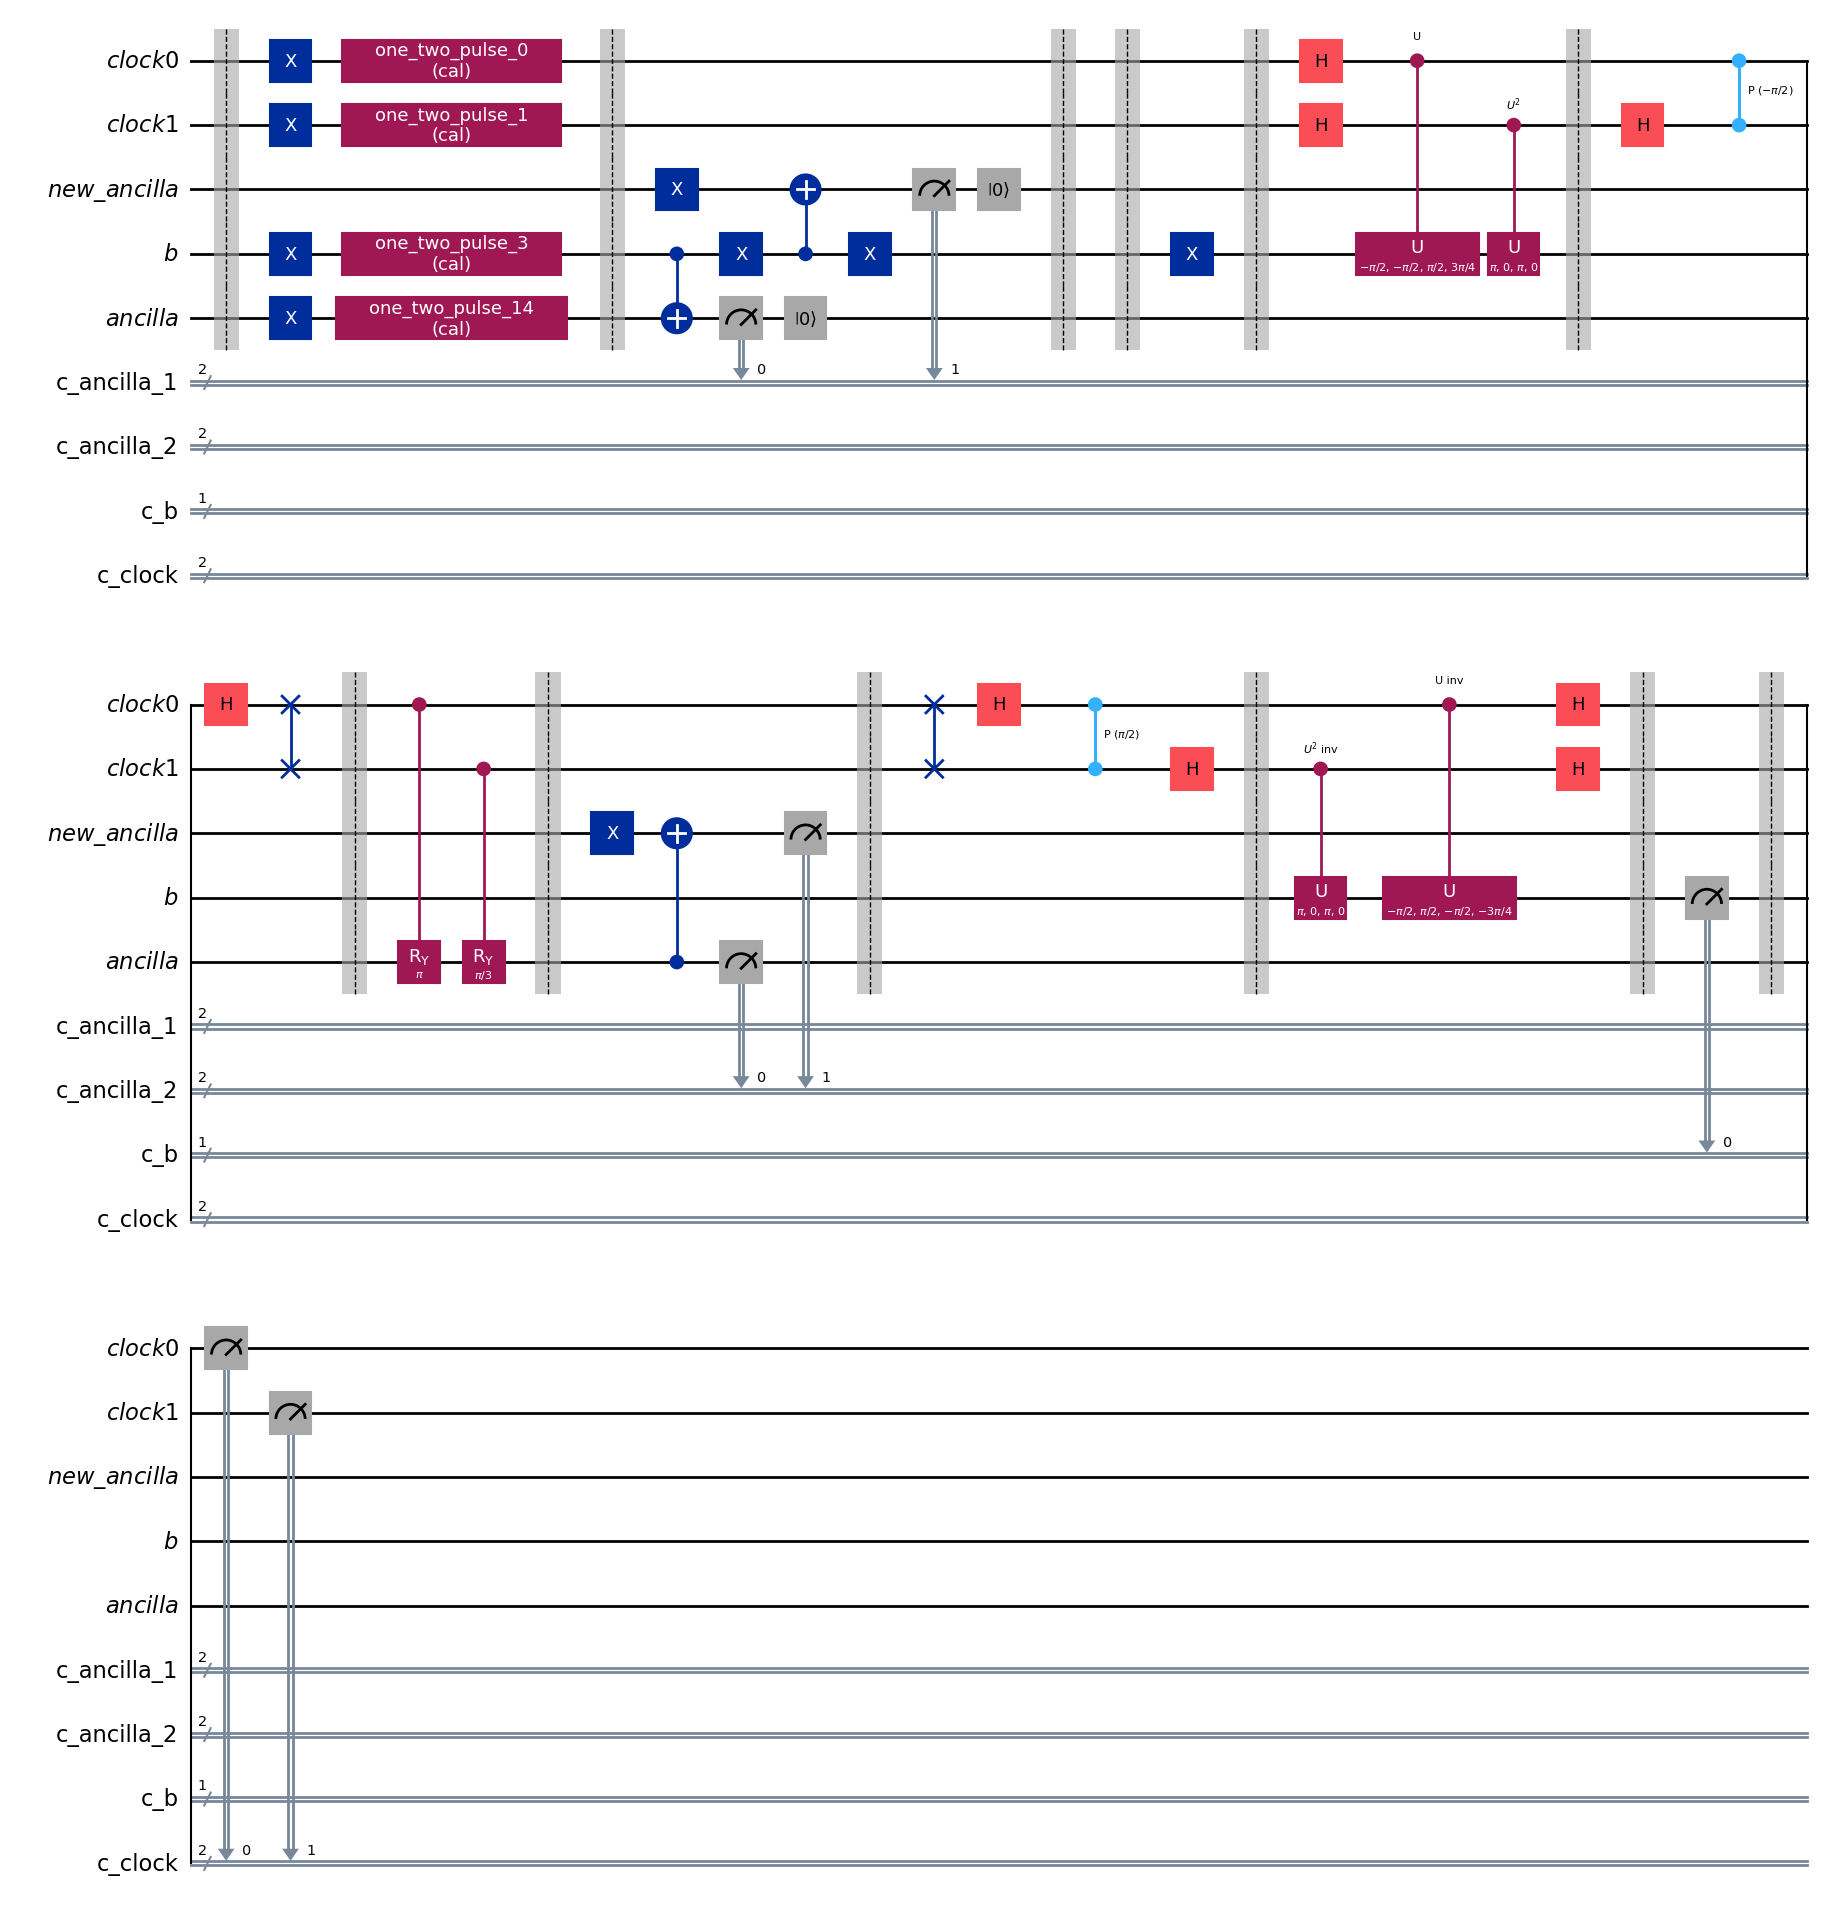

<Figure size 1600x800 with 0 Axes>

In [54]:
fig = plt.figure(figsize=(16, 8))
height = 0.8
hhl.draw('mpl', idle_wires=False)

In [55]:
nShots = 10000
# hhl_tr = transpile(hhl, backend, layout_method='trivial', optimization_level=0)
hhl_tr = transpile(hhl, backend, initial_layout=initial_layout, optimization_level=0)
# hhl_tr.draw(output='mpl', idle_wires=False)

In [58]:
# job = backend.run([hhl_tr], 
#                   meas_level=2, 
#                   meas_return='single', 
#                   shots=nShots)
# job.job_id()

'cw5b3ge6f0t000872r7g'

In [123]:
###### HEA on 4 qubits, all defenses, 10000 shots, [0, 1, 2, 14, 3], ancilla, clock, new_ancilla, b
job_id = "cw5b3exxa9wg0087w2dg"
# job_id = "cw5b3fnvwdtg008221mg"
# job_id = "cw5b3ge6f0t000872r7g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["00 1 01 00"]/counts["00 0 01 00"])
# fig=plot_histogram(counts)
# fig.savefig('', bbox_inches='tight ')
# plot_histogram(counts)

2.25


In [121]:
###### all defenses, 10000 shots, [0, 1, 2, 14, 3], ancilla, clock, new_ancilla, b
job_id1 = "cvb2a30qq7s000885t90"
job_id2 = "cvb2e48a1h6g008ak29g"
job_id3 = "cvb2a70qq7s000885t9g"
job1 = service.job(job_id1)
result1 = job1.result()
counts1 = result1.get_counts()
job2 = service.job(job_id2)
result2 = job2.result()
counts2 = result2.get_counts()
job3 = service.job(job_id3)
result3 = job3.result()
counts3 = result3.get_counts()
print(((counts1["00 1 01 00"]/counts1["00 0 01 00"])+(counts2["00 1 01 00"]/counts2["00 0 01 00"])+(counts3["00 1 01 00"]/counts3["00 0 01 00"]))/3)

1.188395817612863


In [116]:
# counts = np.mean([list(counts1.values()), list(counts2.values()), list(counts3.values())], axis=0)
# print(counts["00 1 01 00"]/counts["00 0 01 00"])

# # fig=plot_histogram(counts)
# # fig.savefig('all_defenses_3.png', bbox_inches='tight ')
# # plot_histogram(counts)

def calculate_counts_mean(counts):
    #keys=[f'{i>>5:02b} {(i>>4)%2:b} {(i>>2)%4:02b} {i%4:02b}' for i in range(128)]
    keys=[f'{i:02b}' for i in range(4)]
    values=np.array([[count[key] if key in count else 0 for count in counts] for key in keys])
    return np.mean(values,axis=1)

def calculate_variational_distance_from_values(values1, values2):
    #values=np.array([[counts1[key],counts2[key]] for key in counts1],dtype=np.float64)
    values1/=np.sum(values1)
    values2/=np.sum(values2)
    return np.sum(np.abs(values1-values2))/2

In [117]:
jobids_HEA=["cw5b3exxa9wg0087w2dg","cw5b3fnvwdtg008221mg","cw5b3ge6f0t000872r7g"]
jobids_nonHEA=["cvb2a30qq7s000885t90","cvb2e48a1h6g008ak29g","cvb2a70qq7s000885t9g"]
counts_HEA = [service.job(jobid).result().get_counts() for jobid in jobids_HEA]
counts_nonHEA = [service.job(jobid).result().get_counts() for jobid in jobids_nonHEA]

In [120]:
calculate_variational_distance_from_values(calculate_counts_mean(counts_HEA),calculate_counts_mean(counts_nonHEA))
# calculate_counts_mean(counts_HEA)
# [[counts_HEA[1][key]] for key in counts_HEA[0]]

0.7523666666666667